In [50]:
# ruff: noqa: F401, E402, T201, T203, D103, B015, B018
from __future__ import annotations

import secrets
from pprint import pprint
from typing import Any, Iterable, Sequence

import matplotlib.pyplot as plt
import networkx as nx
import numba as nb
import numpy as np
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from numpy import dtype, inf, ma, nan, ndarray

InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(edgeitems=5, precision=3, linewidth=300)

## Basics

In [20]:
np.empty((3, 5))
np.full((3, 5), 42)
np.zeros((3, 5))
np.ones((3, 5))

array([[0.837, 0.541, 0.088, 0.267, 0.478],
       [0.786, 0.286, 0.535, 0.12 , 0.049],
       [0.835, 0.802, 0.239, 0.295, 0.462]])

array([[42, 42, 42, 42, 42],
       [42, 42, 42, 42, 42],
       [42, 42, 42, 42, 42]])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

## Check if vector is in the array

### Naive

In [4]:
# Determine if a vector is in NDarray
a = np.arange(15).reshape((3, 5))
a
[0, 1, 2, 3, 4] in a  # Any
(25, 1, 2, 3, 4) in a  # Any
14 in a
25 in a
print("tolist")
[0, 1, 2, 3, 4] in a.tolist()
(0, 1, 2, 3, 4) in a.tolist()
[1, 1, 2, 3, 4] in a.tolist()

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

True

True

True

False

tolist


True

False

False

### Rabin-Karp

In [5]:
@nb.jit
def sum_hash(it: Iterable) -> int:
    s: int = 0
    for e in it:
        s += hash(e)
    return s


@nb.jit
def match(seq: ndarray, subseq: ndarray, start: int) -> bool:
    return np.array_equal(seq[start : start + len(subseq)], subseq)

In [6]:
@nb.jit
def find_rk(seq: ndarray, subseq: ndarray) -> None:
    """Search `seq` for `subseq` using Rabin-Karp over numpy arrays."""
    n: int = len(seq)
    m: int = len(subseq)
    h1: int = sum_hash(seq[:m])
    h2: int = sum_hash(subseq)
    if h1 == h2 and match(seq, subseq, 0):
        yield 0
    for i in range(n - m):
        h1 += hash(seq[i + m]) - hash(seq[i])
        if h1 == h2 and match(seq, subseq, i + 1):
            yield i + 1

In [7]:
seq: ndarray = np.array([[1, 2, 3, 4], [5, 2, 3, 1], [2, 3, 2, 3]]).flatten()
list(find_rk(seq, np.array([2, 3])))

[1, 5, 8, 10]

## NA Rows / Columns

In [31]:
# Remove rows  with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
a
m = ma.masked_invalid(a)
m
r = ma.compress_rows(m)
r

a[~np.isnan(a).any(axis=1),]

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.,  9.],
       [10., 11., 12., 13., 14.]])

masked_array(
  data=[[0.0, 1.0, 2.0, 3.0, 4.0],
        [5.0, 6.0, --, 8.0, 9.0],
        [10.0, 11.0, 12.0, 13.0, 14.0]],
  mask=[[False, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False, False]],
  fill_value=1e+20)

array([[ 0.,  1.,  2.,  3.,  4.],
       [10., 11., 12., 13., 14.]])

array([[ 0.,  1.,  2.,  3.,  4.],
       [10., 11., 12., 13., 14.]])

In [30]:
# Remove columns with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
m = ma.masked_invalid(a)
c = ma.compress_cols(m)
c

a[:, ~np.isnan(a).any(axis=0)]

array([[ 0.,  1.,  3.,  4.],
       [ 5.,  6.,  8.,  9.],
       [10., 11., 13., 14.]])

array([[ 0.,  1.,  3.,  4.],
       [ 5.,  6.,  8.,  9.],
       [10., 11., 13., 14.]])

In [35]:
# Remove rows and columns with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
m = ma.masked_invalid(a)
rc = ma.compress_rowcols(m)
rc

array([[ 0.,  1.,  3.,  4.],
       [10., 11., 13., 14.]])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 5

## Remove dimensions of size 1

In [9]:
a = np.arange(15).reshape((1, 3, 5))
a
a.squeeze()

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]]])

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

## Most Frequent Value

In [10]:
a: ndarray = np.array([[1, 2, 2, 2, 4], [3, 4, 2, 5, 1], [5, 2, 7, 8, 9]])
a
bc = np.bincount(a.flat)
bc
bc.argmax()

array([[1, 2, 2, 2, 4],
       [3, 4, 2, 5, 1],
       [5, 2, 7, 8, 9]])

array([0, 2, 5, 1, 2, 2, 0, 1, 1, 1])

2

In [63]:
a = np.array([[1, 2, 2, 2, 4], [3, 4, 2, 5, 1], [5, 2, 7, 8, 9]])
nums, counts = np.unique(a, return_counts=1)
nums
counts
nums[np.argmax(counts)]

array([1, 2, 3, 4, 5, 7, 8, 9])

array([2, 5, 1, 2, 2, 1, 1, 1])

2

## Combine 1D and 2D array

In [11]:
a = np.array([[1, 2, 4], [6, 5, 3]])
b = np.array([3, 2, 1])

np.block([[a], [b]])

array([[1, 2, 4],
       [6, 5, 3],
       [3, 2, 1]])

## Combinations

In [12]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

np.array(np.meshgrid(a, b)).shape
np.array(np.meshgrid(a, b)).T.shape
np.array(np.meshgrid(a, b)).T.reshape(-1, 2)

(2, 5, 5)

(5, 5, 2)

array([[ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 3, 14],
       [ 4, 10],
       [ 4, 11],
       [ 4, 12],
       [ 4, 13],
       [ 4, 14]])

In [62]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10
np.concatenate(np.dstack(np.meshgrid(a, b)))

array([[ 0, 10],
       [ 1, 10],
       [ 2, 10],
       [ 3, 10],
       [ 4, 10],
       [ 0, 11],
       [ 1, 11],
       [ 2, 11],
       [ 3, 11],
       [ 4, 11],
       [ 0, 12],
       [ 1, 12],
       [ 2, 12],
       [ 3, 12],
       [ 4, 12],
       [ 0, 13],
       [ 1, 13],
       [ 2, 13],
       [ 3, 13],
       [ 4, 13],
       [ 0, 14],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14],
       [ 4, 14]])

(0.0, 29.999995141332942)

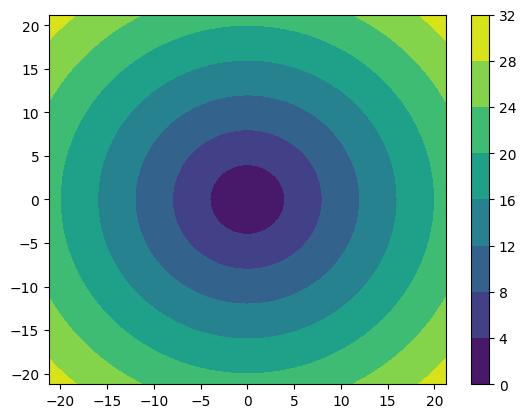

In [22]:
x: ndarray = np.linspace(-21.2132, 21.2132, 101)
y: ndarray = np.linspace(-21.2132, 21.2132, 101)
xx, yy = np.meshgrid(x, y, sparse=True)
zz = np.sqrt(xx**2 + yy**2)
zz.min(), zz.max()

_ = plt.contourf(x, y, zz)
_ = plt.colorbar()
_ = plt.show()

## How to add border?

In [14]:
a = np.arange(16).reshape((4, 4))
np.pad(a, 1)

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  3,  0],
       [ 0,  4,  5,  6,  7,  0],
       [ 0,  8,  9, 10, 11,  0],
       [ 0, 12, 13, 14, 15,  0],
       [ 0,  0,  0,  0,  0,  0]])

## Compare two ndarrays?

In [15]:
a: ndarray = np.array([1, 2, 3, 4])
b: ndarray = np.array([2, 4, 6, 8])

np.array_equal(a, b)
a == b
np.less_equal(a, b)
a < b

False

array([False, False, False, False])

array([ True,  True,  True,  True])

array([ True,  True,  True,  True])

## Check if value is in ndarray?

In [16]:
a: ndarray = np.array([1, 2, 3, 4])
b: ndarray = np.array([2, 4, 6, 8])

3 in a

(a == 3).any()

True

True

## Diagonals of a 3D array

In [17]:
a = np.arange(27).reshape((3, 3, 3))
a

d1 = np.diagonal(a)
d1
d2 = np.diagonal(a, axis1=0, axis2=2)
d2
d3 = np.diagonal(a, axis1=1, axis2=2)
d3

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([[ 0, 12, 24],
       [ 1, 13, 25],
       [ 2, 14, 26]])

array([[ 0, 10, 20],
       [ 3, 13, 23],
       [ 6, 16, 26]])

array([[ 0,  4,  8],
       [ 9, 13, 17],
       [18, 22, 26]])

In [18]:
np.diagonal(d1)
np.diagonal(np.flipud(d1))
np.diagonal(np.flipud(d2))
np.diagonal(np.fliplr(d3))

array([ 0, 13, 26])

array([ 2, 13, 24])

array([ 6, 13, 20])

array([ 8, 13, 18])

## Flatten Matrix

In [19]:
a = np.arange(27).reshape((3, 3, 3))
a
a.flatten()

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## Move / Swap Axes

In [20]:
a = np.arange(27).reshape((3, 3, 3))
a
np.moveaxis(a, 1, 2)

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([[[ 0,  3,  6],
        [ 1,  4,  7],
        [ 2,  5,  8]],

       [[ 9, 12, 15],
        [10, 13, 16],
        [11, 14, 17]],

       [[18, 21, 24],
        [19, 22, 25],
        [20, 23, 26]]])

In [21]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.moveaxis(b, 1, 2).shape
np.moveaxis(b, 1, 2)
np.swapaxes(b, 1, 2).shape
np.swapaxes(b, 1, 2)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

(2, 4, 3)

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

(2, 4, 3)

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

In [22]:
np.moveaxis(b, 0, 2).shape
np.moveaxis(b, 0, 2)
np.swapaxes(b, 0, 2).shape
np.swapaxes(b, 0, 2)

(3, 4, 2)

array([[[ 0, 12],
        [ 1, 13],
        [ 2, 14],
        [ 3, 15]],

       [[ 4, 16],
        [ 5, 17],
        [ 6, 18],
        [ 7, 19]],

       [[ 8, 20],
        [ 9, 21],
        [10, 22],
        [11, 23]]])

(4, 3, 2)

array([[[ 0, 12],
        [ 4, 16],
        [ 8, 20]],

       [[ 1, 13],
        [ 5, 17],
        [ 9, 21]],

       [[ 2, 14],
        [ 6, 18],
        [10, 22]],

       [[ 3, 15],
        [ 7, 19],
        [11, 23]]])

## Fibonacci Series

In [23]:
@nb.jit
def imatmul2d(a: ndarray, b: ndarray) -> None:
    a[0, 0], a[0, 1], a[1, 0], a[1, 1] = (
        a[0, 0] * b[0, 0] + a[0, 1] * b[1, 0],
        a[0, 0] * b[0, 1] + a[0, 1] * b[1, 1],
        a[1, 0] * b[0, 0] + a[1, 1] * b[1, 0],
        a[1, 0] * b[0, 1] + a[1, 1] * b[1, 1],
    )


@nb.jit
def imatmul1d2d(a: ndarray, b: ndarray) -> None:
    a[0], a[1] = (a[0] * b[0, 0] + a[1] * b[1, 0], a[0] * b[0, 1] + a[1] * b[1, 1])


@nb.jit
def fib(n: int) -> int:
    """Return fibonacci number: `(fib(n-1) + fib(n-2))`."""  # noqa: D402
    # Runs in O(log N)
    mat: ndarray = np.array([[1, 1], [1, 0]], dtype=np.int64)
    res: ndarray = np.array([1, 0], dtype=np.int64)
    n -= 2
    while n > 0:
        if n & 1:
            imatmul1d2d(res, mat)
        imatmul2d(mat, mat)
        n >>= 1
    return res[0] + res[1]

In [24]:
fib(3)
fib(10)

2

55

## Count non-zero elements

In [25]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.count_nonzero(b)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

23

## Size


In [26]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.size(b)
np.size(b, axis=0)
np.size(b, axis=1)
np.size(b, axis=2)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

24

2

3

4

## Trim Zeros

In [30]:
b = np.arange(5)
b.shape
b
p = np.pad(b, 3)
p
np.trim_zeros(p)

(5,)

array([0, 1, 2, 3, 4])

array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0])

array([1, 2, 3, 4])

## Change Data Type

In [32]:
b = np.arange(5)

f = np.asarray(b, dtype=float)
f

array([0., 1., 2., 3., 4.])

## Reverse

In [33]:
np.flip(np.arange(5))

array([4, 3, 2, 1, 0])

## Read-Only

In [38]:
a = np.arange(5)
a.flags
a.flags["W"] = False
a

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

array([0, 1, 2, 3, 4])

In [44]:
a = np.array([1, 2, 3, 4, 5])
a.flags
a.flags.writeable = False
a.flags
a.setflags(write=True)
a.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

## Sum of values

In [45]:
b = np.arange(6).reshape((2, 3))
b.shape
b
b.sum()

(2, 3)

array([[0, 1, 2],
       [3, 4, 5]])

15

In [47]:
b = np.arange(9).reshape((3, 3))
b.shape
b
b.trace()

(3, 3)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

12

## +/-

In [48]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[4, 5], [6, 7]])

a + b
a - b

array([[ 5,  7],
       [ 9, 11]])

array([[-3, -3],
       [-3, -3]])

## Insert / Add

In [59]:
a = np.array([[1, 2], [3, 4]])

np.insert(a, 1, [5, 6], axis=0)
np.insert(a, 1, [5, 6], axis=1)

array([[1, 2],
       [5, 6],
       [3, 4]])

array([[1, 5, 2],
       [3, 6, 4]])

In [54]:
a = np.array([[1, 2], [3, 4]])
np.block([[a], [5, 6]])
np.vstack((a, [5, 6]))
np.hstack((a, np.array([[5, 6]]).T))

array([[1, 2],
       [3, 4],
       [5, 6]])

array([[1, 2],
       [3, 4],
       [5, 6]])

array([[1, 2, 5],
       [3, 4, 6]])

## Outer / Inner / Cross

In [80]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 0])
np.outer(a, b)
np.inner(a, b)
np.dot(a, b)
np.cross(a, b)

array([[1, 2, 0],
       [2, 4, 0],
       [3, 6, 0]])

5

5

array([-6,  3,  0])

## Covariance / Correlation

In [116]:
a = np.array([1, 2, 3, 8, 3])
b = np.array([1, 2, 0, -1, 3])

np.cov(a, b)
np.corrcoef(a, b)

array([[ 7.3 , -2.75],
       [-2.75,  2.5 ]])

array([[ 1.        , -0.64372631],
       [-0.64372631,  1.        ]])

In [119]:
a = np.array([1, 2, 3, 8, 3])
b = np.array([1, 2, 0, -1, 3])

c = np.cov(a, b)
c

invd = np.diag(1 / np.sqrt(c.diagonal()))
invd

invd @ c @ invd

array([[ 7.3 , -2.75],
       [-2.75,  2.5 ]])

array([[0.37011661, 0.        ],
       [0.        , 0.63245553]])

array([[ 1.        , -0.64372631],
       [-0.64372631,  1.        ]])

## Kronecker Product

In [6]:
a = np.array([[1, 2], [3, 5]])
b = np.array([[10, -20], [100, -200]])

np.kron(a, b)

array([[   10,   -20,    20,   -40],
       [  100,  -200,   200,  -400],
       [   30,   -60,    50,  -100],
       [  300,  -600,   500, -1000]])

## Convert To List

In [9]:
a = np.array([[1, 2], [3, 5]])
list(a)

a.flatten()

a.tolist()

[array([1, 2]), array([3, 5])]

array([1, 2, 3, 5])

[[1, 2], [3, 5]]

## Replace elements conditionally

In [23]:
a = np.array([[1, 2], [3, 5]])

c = (a % 2) == 0
c
c = (a & 1) == 0
c
a[c] = 7
a

np.where(c, -1, a)

array([[False,  True],
       [False, False]])

array([[False,  True],
       [False, False]])

array([[1, 7],
       [3, 5]])

array([[ 1, -1],
       [ 3,  5]])

## True Indexes

In [28]:
a = np.array([[1, 2, 7], [4, 3, 2]])

np.argwhere(a & 1)

array([[0, 0],
       [0, 2],
       [1, 1]])

## Replace NaN with column avg.

In [51]:
a = np.array([[nan, 2, 7], [4, nan, 2], [nan, 9, nan]])
a
a[2, 0]
a[0, 2]
i = np.nonzero(np.isnan(a))
print("row", "column")
i
a[i] = np.take(np.nanmean(a, axis=0), i[1])
a

array([[nan,  2.,  7.],
       [ 4., nan,  2.],
       [nan,  9., nan]])

nan

7.0

row column


(array([0, 1, 2, 2]), array([0, 1, 0, 2]))

array([[4. , 2. , 7. ],
       [4. , 5.5, 2. ],
       [4. , 9. , 4.5]])

In [46]:
a = np.array([[nan, 2, 7], [4, nan, 2], [nan, 9, nan]])
a
# Broadcast the
np.where(np.isnan(a), np.nanmean(a, axis=0), a)

array([[nan,  2.,  7.],
       [ 4., nan,  2.],
       [nan,  9., nan]])

array([[4. , 2. , 7. ],
       [4. , 5.5, 2. ],
       [4. , 9. , 4.5]])

## Replace negative with zero

In [53]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
a[a < 0] = 0
a

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

In [54]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
a.clip(0)

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

In [56]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
np.maximum(a, 0)

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

## Zero Index

In [72]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0]])
a.shape
np.argwhere(a == 0)
np.nonzero(a == 0)
np.array(np.nonzero(a == 0)).T
np.stack(np.nonzero(a == 0), axis=1)

(3, 3)

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

(array([0, 1, 2, 2]), array([0, 1, 0, 2]))

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

## Access Columns, Rows

In [42]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0]])
a
a[..., [2, 1]]
a[:, [2, 1]]
a[[2, 1],]

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

array([[7, 2],
       [2, 0],
       [0, 9]])

array([[7, 2],
       [2, 0],
       [0, 9]])

array([[0, 9, 0],
       [4, 0, 2]])

## Row numbers with element larger than X

In [47]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0], [1, 3, 0], [11, 3, 0], [1, 3, 6]])

np.argwhere(a > 5)[:, 0]

array([0, 2, 4, 5])

In [49]:
np.nonzero((a > 5).any(axis=1))

(array([0, 2, 4, 5]),)

## Fill the diagonals

In [53]:
a = np.arange(16).reshape((4, 4))
a
a[np.diag_indices_from(a)] = 33
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

array([[33,  1,  2,  3],
       [ 4, 33,  6,  7],
       [ 8,  9, 33, 11],
       [12, 13, 14, 33]])

In [54]:
a = np.arange(16).reshape((4, 4))
np.fill_diagonal(a, 33)
a

array([[33,  1,  2,  3],
       [ 4, 33,  6,  7],
       [ 8,  9, 33, 11],
       [12, 13, 14, 33]])

## Check if elements are in array

In [55]:
h = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0], [1, 3, 0], [11, 3, 0], [1, 3, 6]])
np.isin([5, 4, 3], h)

array([False,  True,  True])

In [56]:
np.isin([[5, 4, 3], [1, 2, 3]], h)

array([[False,  True,  True],
       [ True,  True,  True]])

## Combine two on the 3rd dimension

In [64]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

m = np.meshgrid(a, b)
m
np.dstack(m)

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12],
        [13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14]])]

array([[[ 0, 10],
        [ 1, 10],
        [ 2, 10],
        [ 3, 10],
        [ 4, 10]],

       [[ 0, 11],
        [ 1, 11],
        [ 2, 11],
        [ 3, 11],
        [ 4, 11]],

       [[ 0, 12],
        [ 1, 12],
        [ 2, 12],
        [ 3, 12],
        [ 4, 12]],

       [[ 0, 13],
        [ 1, 13],
        [ 2, 13],
        [ 3, 13],
        [ 4, 13]],

       [[ 0, 14],
        [ 1, 14],
        [ 2, 14],
        [ 3, 14],
        [ 4, 14]]])

## LinAlg

### Matrix Norm

In [85]:
a = np.arange(16).reshape((4, 4))
a
"fro", np.linalg.norm(a)
1, np.linalg.norm(a, 1)
-1, np.linalg.norm(a, -1)
2, np.linalg.norm(a, 2)
-2, np.linalg.norm(a, -2)
"inf", np.linalg.norm(a, inf)
"-inf", np.linalg.norm(a, -inf)

"nuc", np.linalg.norm(a, "nuc")

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

('fro', 35.21363372331802)

(1, 36.0)

(-1, 24.0)

(2, 35.13996365902469)

(-2, 9.848750822853081e-17)

('inf', 54.0)

('-inf', 6.0)

('nuc', 37.41657386773941)

In [82]:
a = np.arange(16).reshape((4, 4))
a
np.max(np.sum(np.abs(a), axis=0))
np.max(np.sum(np.abs(a), axis=1))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

36

54

In [47]:
v = np.array([1, 2, -2])
np.linalg.norm(v, 1)
np.linalg.norm(v, 2)

5.0

3.0

### Determinant

In [ ]:
a = np.array([[1, 2], [3, 4]])
np.linalg.det(a)

-2.0000000000000004

In [ ]:
a = np.eye(3)
np.linalg.det(a)

1.0

### Inverse

In [ ]:
a = np.eye(3)
np.linalg.inv(a)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
a = np.array([[1, 2], [3, 4]])
a
i = np.linalg.inv(a)
i

a @ i

array([[1, 2],
       [3, 4]])

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])

### QR Decomposition

In [17]:
a = np.arange(16).reshape((4, 4))

q, r = np.linalg.qr(a)
q
r

array([[ 0.   , -0.837,  0.541,  0.088],
       [-0.267, -0.478, -0.786,  0.286],
       [-0.535, -0.12 , -0.049, -0.835],
       [-0.802,  0.239,  0.295,  0.462]])

array([[-1.497e+01, -1.657e+01, -1.817e+01, -1.978e+01],
       [ 0.000e+00, -1.195e+00, -2.390e+00, -3.586e+00],
       [ 0.000e+00,  0.000e+00, -3.820e-15, -4.311e-15],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  7.744e-17]])

### Condition Number

Describes the relative quotient of change for $Ax = y$ between `dx` (solution) and `dy` (input). 
$$\frac{||dx||}{||x||} \leq k(A)  \frac{||dy||}{||y||}$$ 
  

In [44]:
a = (np.arange(16).reshape((4, 4)) - 10) / 30.0

np.linalg.det(a)
n = np.linalg.norm(a)
"||a||", n
invn = np.linalg.norm(np.linalg.inv(a))
"||a-1||", invn
"||a|| * ||a-1||", n * invn

"||a||_max_1 / ||a||_min_1", np.linalg.norm(a, 1) / np.linalg.norm(a, -1)
"||a||_max_2 / ||a||_min_2", np.linalg.norm(a, 2) / np.linalg.norm(a, -2)

"cond", np.linalg.cond(a)

-1.2839532962581623e-35

('||a||', 0.699205898780101)

('||a-1||', 1.7353766674558582e+17)

('||a|| * ||a-1||', 1.2133856024904898e+17)

('||a||_max_1 / ||a||_min_1', 1.25)

('||a||_max_2 / ||a||_min_2', 8.511418100523576e+16)

('cond', 8.511418100523576e+16)

### Eigenvalues and vectors

Eigenvalues represent the characteristic response of a matrix with respect to the eigenvector.
$$Av = \lambda v$$

In [51]:
a = (np.arange(16).reshape((4, 4)) - 10) / 30.0

np.linalg.eig(a)

EigResult(eigenvalues=array([-5.082e-01, -1.195e-17,  1.749e-01,  2.680e-17]), eigenvectors=array([[ 0.835, -0.548, -0.503,  0.317],
       [ 0.495,  0.73 , -0.074, -0.089],
       [ 0.154,  0.183,  0.355, -0.772],
       [-0.186, -0.365,  0.784,  0.544]]))


In [ ]:
a = np.array([[1, 2], [3, 4]])
np.linalg.eig(a)

EigResult(eigenvalues=array([-0.37228,  5.37228]), eigenvectors=array([[-0.82456, -0.41597],
       [ 0.56577, -0.90938]]))

In [ ]:
a = np.eye(3)
np.linalg.eig(a)

EigResult(eigenvalues=array([1., 1., 1.]), eigenvectors=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))

### Euclidean Distance

In [53]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

np.linalg.norm(a - b)  # 2 norm

22.360679774997898

In [58]:
d = a - b

np.sqrt(np.dot(d, d))

22.360679774997898

In [59]:
np.sqrt(np.sum(d**2))

22.360679774997898

## Random

In [91]:
rng = np.random.default_rng()

### Random Array

In [92]:
rng.random(10)

array([0.191, 0.582, 0.993, 0.463, 0.747, 0.953, 0.856, 0.453, 0.931, 0.675])

In [99]:
rng.uniform(-5, 5, size=10)

array([-2.797, -2.069,  0.733,  1.568,  2.504,  3.947,  4.599,  3.54 ,  1.731, -0.448])

In [93]:
rng.integers(0, 10, size=10)

array([2, 7, 5, 8, 1, 7, 3, 5, 6, 0])

In [98]:
np.empty(10)

array([0.565, 0.388, 0.332, 0.143, 0.811, 0.697, 0.711, 0.857, 0.438, 0.41 ])

### Choose by probability

In [90]:
a = np.array([9.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.9, 0.1, 0.1, 0.1])
a
p = a / a.sum()
s = np.array(list("abcdefghij"))
s
rng.choice(s, p=p, size=10)

array([9.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.9, 0.1, 0.1, 0.1])

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype='<U1')

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 'a'], dtype='<U1')

## Sorting / Searching

### Sorted Idices

In [105]:
a = rng.integers(1, 20, size=20)
a
np.argsort(a)

array([17,  9,  2, 17,  5,  7, 16, 12,  3, 13, 18,  2,  1,  3, 13,  5,  5,  3, 16,  6])

array([12,  2, 11, 17,  8, 13,  4, 16, 15, 19,  5,  1,  7, 14,  9, 18,  6,  3,  0, 10])

### K-Smallest Values

In [107]:
a = rng.integers(1, 20, size=20)
a
s = np.sort(a)
s[:3]

array([ 8, 11, 18, 14, 13,  6, 16,  3,  5, 13,  2,  1,  8, 12,  7, 19,  2,  9,  3, 17])

array([1, 2, 2])

In [109]:
p = np.partition(a, 3)
p
p[:3]

array([ 2,  1,  2,  3,  7,  6,  3,  5,  8, 11,  8,  9, 12, 13, 16, 19, 13, 14, 18, 17])

array([2, 1, 2])

### K-Largest Values

In [110]:
a = rng.integers(1, 20, size=20)
a
p = np.partition(a, -3)
p[-3:]

array([ 7, 11, 15,  7,  6,  5,  3, 12, 10, 12,  8,  9, 16, 11, 16, 17, 13, 18, 12, 13])

array([16, 17, 18])